# Analysis of ATLAS-GAN results

Let's take a look at the results of the DCGAN trained to generate ATLAS RPV SUSY events.

In [29]:
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import torch
from torch.autograd import Variable

%matplotlib notebook

## Load results from training

In [2]:
results_dir = '/global/cscratch1/sd/sfarrell/atlas_gan/AtlasDCGAN_001'

In [3]:
ls $results_dir

README                dis_outputs_real.npy  gen_samples.npy
dis_losses.npy        discriminator.torch   generator.torch
dis_outputs_fake.npy  gen_losses.npy        out.log


In [24]:
# Load the generator
generator = torch.load(os.path.join(results_dir, 'generator.torch'))
generator.eval()

Generator(
  (network): Sequential(
    (0): ConvTranspose2d (64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [4]:
# Load the result arrays
dis_losses = np.load(os.path.join(results_dir, 'dis_losses.npy'))
gen_losses = np.load(os.path.join(results_dir, 'gen_losses.npy'))
dis_outputs_real = np.load(os.path.join(results_dir, 'dis_outputs_real.npy'))
dis_outputs_fake = np.load(os.path.join(results_dir, 'dis_outputs_fake.npy'))
gen_samples = np.load(os.path.join(results_dir, 'gen_samples.npy'))

<IPython.core.display.Javascript object>


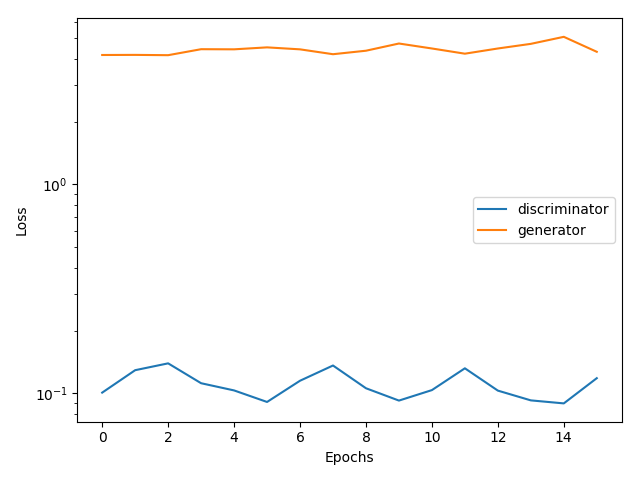

In [5]:
# Plot training loss
plt.figure()
plt.semilogy(dis_losses, label='discriminator')
plt.semilogy(gen_losses, label='generator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.tight_layout()

<IPython.core.display.Javascript object>


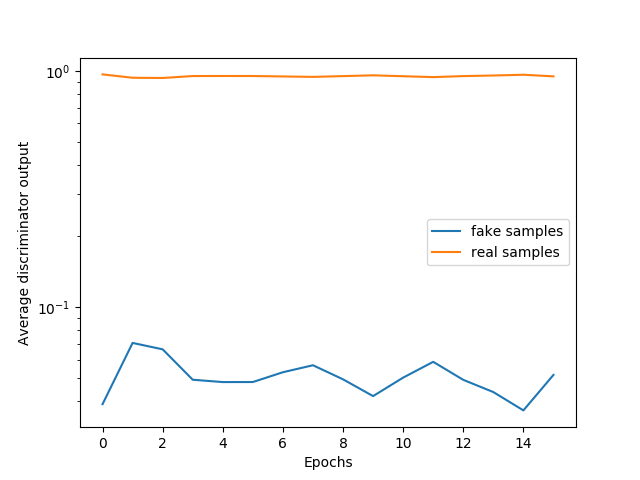

In [6]:
# Plot the discriminator average outputs per epoch
plt.figure()
plt.semilogy(dis_outputs_fake, label='fake samples')
plt.semilogy(dis_outputs_real, label='real samples')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Average discriminator output')

In [7]:
gen_samples.shape

(16, 8, 64, 64)

In [8]:
# Threshold the image to remove the noise and sparsify
thresh = 0.00008
corrected_samples = gen_samples.copy()
corrected_samples[corrected_samples < thresh] = 0

In [60]:
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax)
        cbar.set_label('Normalized Energy')
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

## Draw example generated samples from training epochs

<IPython.core.display.Javascript object>


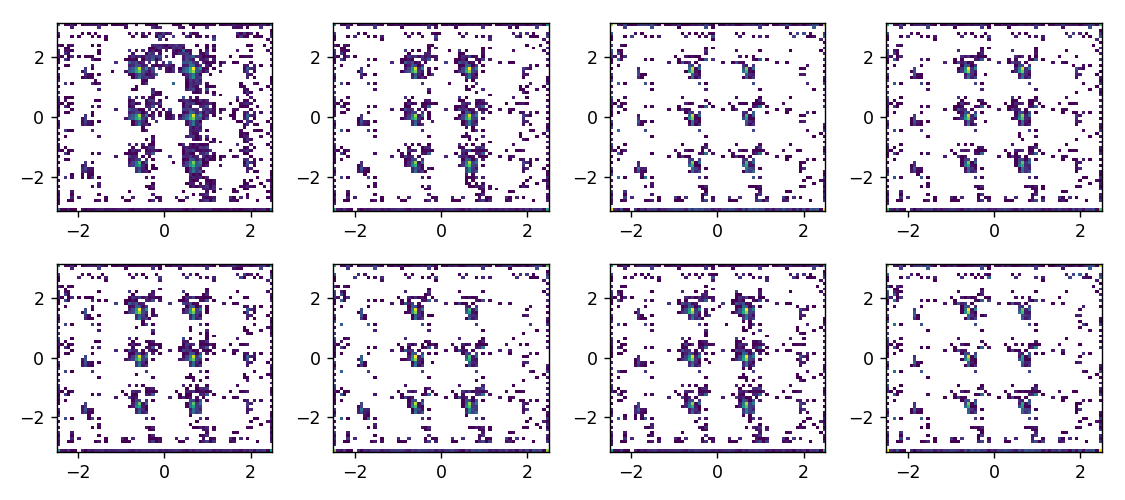

<IPython.core.display.Javascript object>


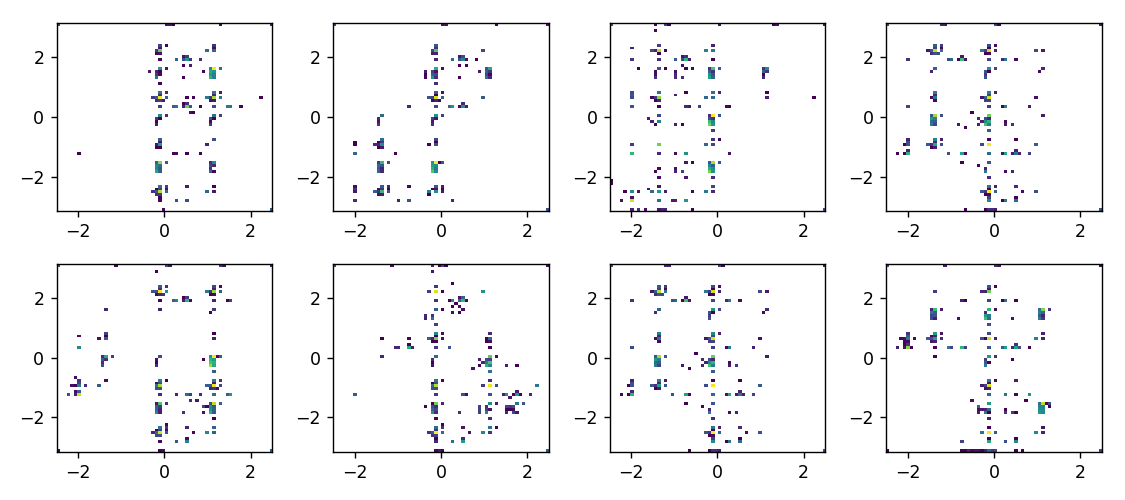

<IPython.core.display.Javascript object>


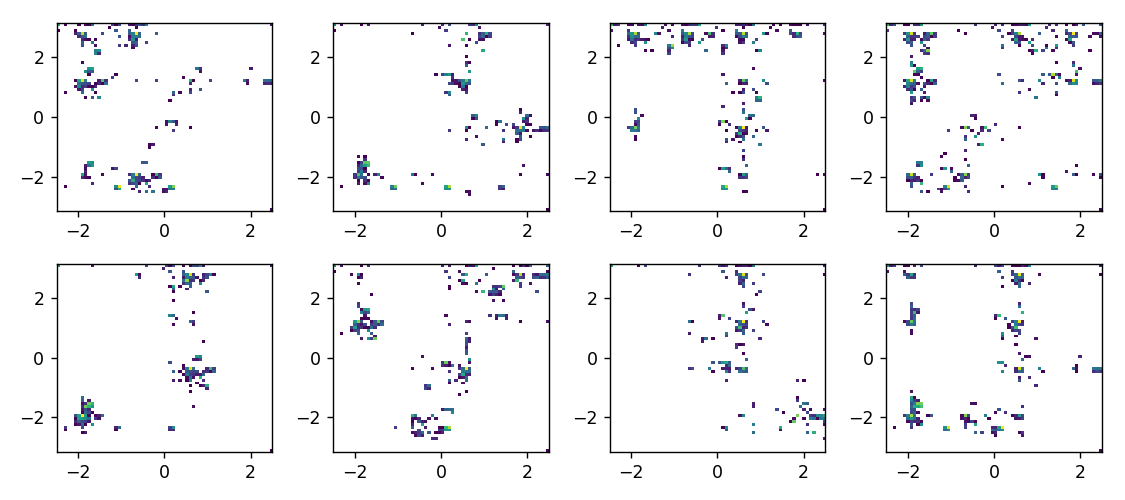

<IPython.core.display.Javascript object>


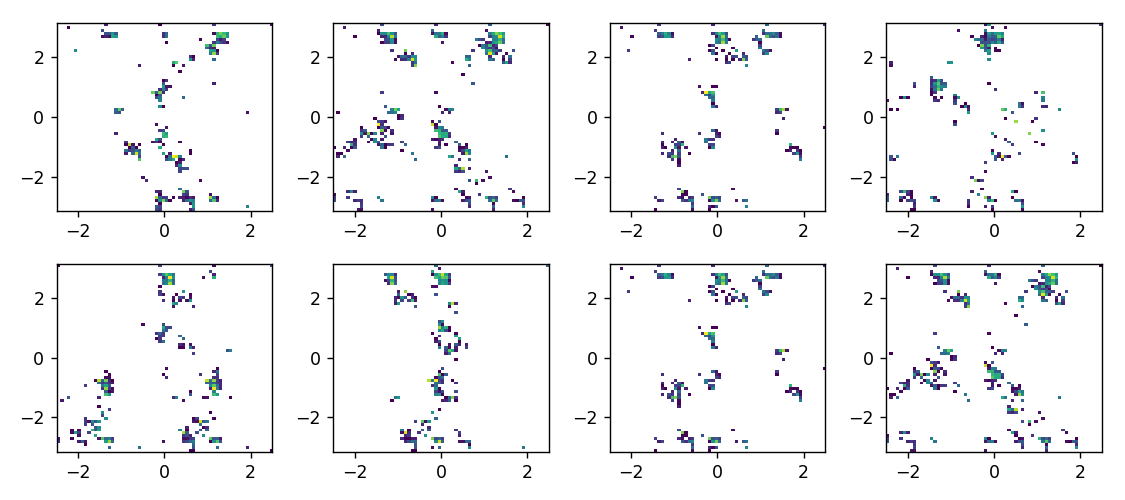

<IPython.core.display.Javascript object>


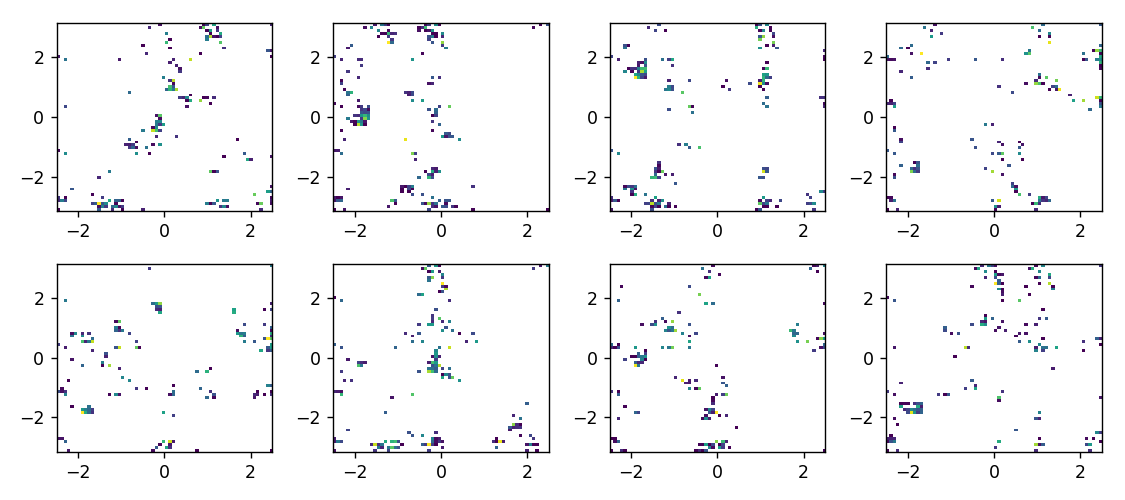

<IPython.core.display.Javascript object>


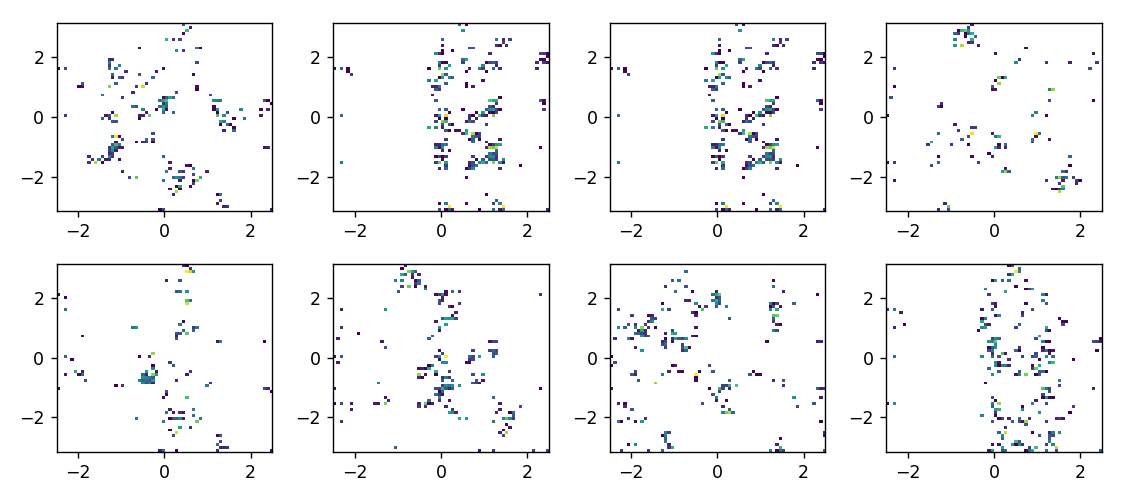

In [61]:
# Draw some samples from selected epoch
epochs = [0, 1, 2, 3, 7, 15]
for epoch in epochs:
    fig, axs = plt.subplots(2, 4, figsize=(9,4))
    for i, ax in enumerate(axs.flatten()):
        draw_image(corrected_samples[epoch, i], vmin=1e-4, ax=ax,
                   draw_cbar=False, xlabel=None, ylabel=None)
    plt.tight_layout()

Hmmm, two of those samples at the end are identical. That's a problem...

## Generate new samples

In [62]:
def generate_samples(generator, n, noise_dim=64):
    # Generate input noise
    noise = Variable(torch.FloatTensor(n, noise_dim, 1, 1)
                 .normal_(0, 1))
    # Generate new samples
    samples = generator(noise)
    return samples.data.numpy().squeeze(1)

def correct_samples(x, thresh=0.00008):
    x = x.copy()
    x[x < thresh] = 0
    return x

In [63]:
# Config
n_gen = 16

In [64]:
samples = correct_samples(generate_samples(generator, n_gen))

<IPython.core.display.Javascript object>


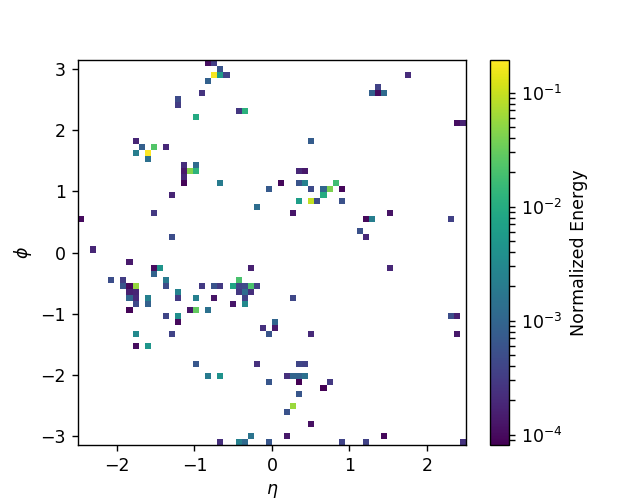

<IPython.core.display.Javascript object>


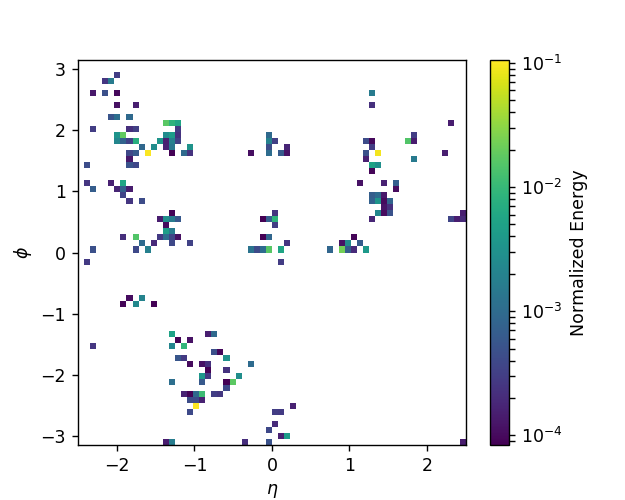

<IPython.core.display.Javascript object>


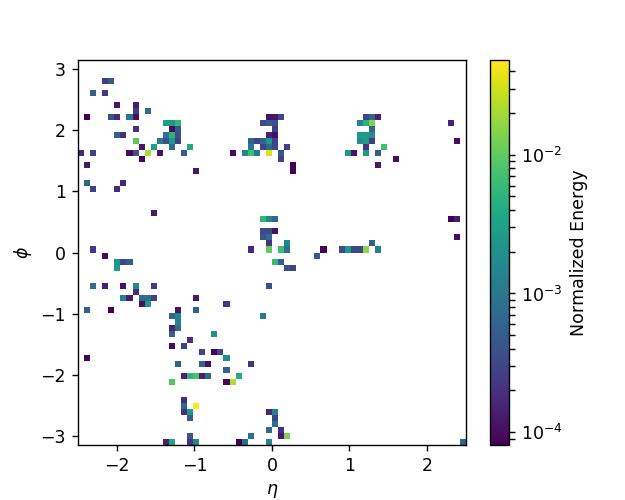

<IPython.core.display.Javascript object>


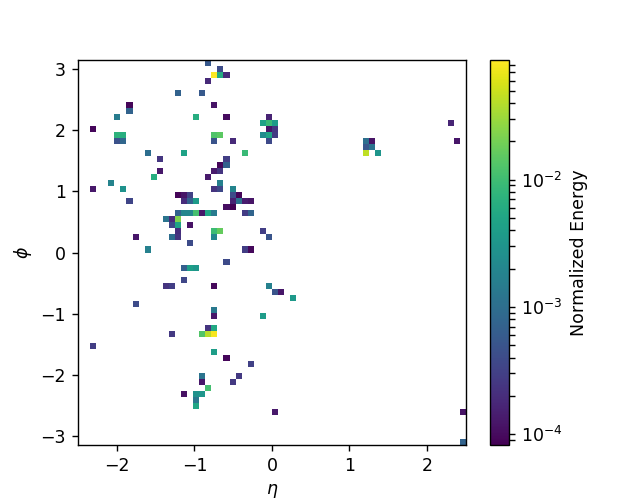

In [65]:
draw_image(samples[0])
draw_image(samples[1])
draw_image(samples[2])
draw_image(samples[3])

## Reconstruct jets from generated samples

- TODO: need pyjet installed
- TODO: need normalization